In [ ]:
"""
In this file the SVC model is tuned. 
Hyperparameters include: C; kernel, gamma (for poly and rbf kernels); degree (for poly kernel); coef0 (for poly kernel)
Learning curves are constructed. 
The final model is evaluated 
"""

In [2]:
import numpy as np
import pandas as pd
pd.options.display.max_columns=None
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, validation_curve, learning_curve, GridSearchCV, ParameterGrid, KFold, cross_validate
from sklearn.svm import SVC
from sklearn import preprocessing
from datetime import date
import nbimporter
from Data import load_training_test_sets
import time

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

## Import Data

In [3]:
X_train, X_test, y_train, y_test=load_training_test_sets()

scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

scaler = preprocessing.StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

Import Data: Complete
Train shape:  (32561, 15) 
Test shape:  (16281, 15) 
Columns:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14] 

Process and Split Data: Complete 

Undersample data: Complete
Balanced train data:  (18664, 85)
Imbalanced test data:  (9769, 85) 



## Tuning

In [9]:
def tune(X_train, y_train, param, param_range, clf=SVC(random_state=0), show_plot=True):
    #clf = SVC(random_state=0)
    
    clf_gs=GridSearchCV(estimator = clf, scoring='f1', param_grid=ParameterGrid({'{}'.format(param): [param_range]}))
 
    clf_gs.fit(X_train, y_train)
    best_param=clf_gs.best_params_[str(param)]
    best_score=round(clf_gs.best_score_, 3)
    
    print(color.BOLD+'Tuning Parameter: {}'.format(param)+color.END)
    print('Best Parameter: ', best_param)
    print('Best Score: ', best_score)
    
    if show_plot==True: 
        train_scores, test_scores=validation_curve(clf, X_train, y_train, param_name=param, param_range=param_range, scoring='f1', cv=kf)
        fig, ax = plt.subplots()
        fig.set_size_inches(10,6)
        ax.plot(range(len(param_range)), np.mean(train_scores, axis=1), '-o', label='Train')
        ax.plot(range(len(param_range)), np.mean(test_scores, axis=1), '-o', label='Val')

        ax.set_title('Validation Curve: {}'.format(param))
        ax.set_xlabel('N')
        ax.set_ylabel('F1')
        ax.set_xticks(range(len(param_range)))
        ax.set_xticklabels(param_range)
        ax.legend()
    

Tuning Parameter: C
Best Parameter:  1.0
Best Score:  0.817


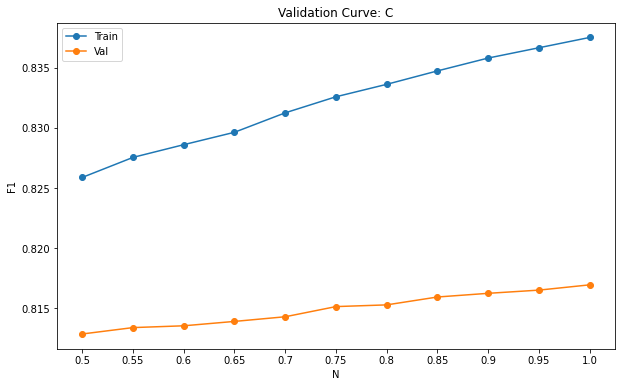

In [5]:
param='C'
param_range=np.array(range(50,101, 5))/100
tune(X_train, y_train, param, param_range)

Tuning Parameter: kernel
Best Parameter:  linear
Best Score:  0.824


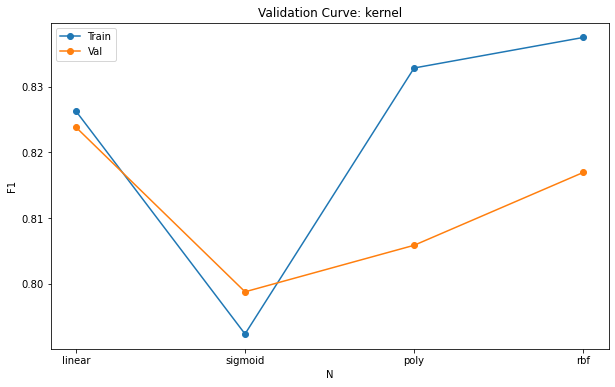

In [6]:
param='kernel'
param_range=np.array(['linear', 'sigmoid', 'poly', 'rbf'])
tune(X_train, y_train, param, param_range)

Tuning Parameter: degree
Best Parameter:  3
Best Score:  0.805


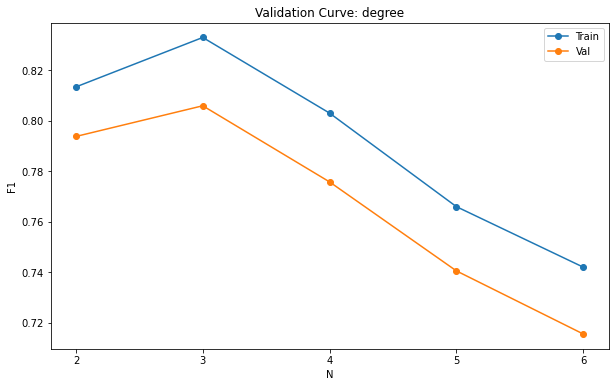

In [10]:
param='degree'
param_range=np.array(range(2, 7))
clf=SVC(kernel='poly',  random_state=0)
tune(X_train, y_train, param, param_range, clf=clf)

Tuning Parameter: gamma
Best Parameter:  0.019
Best Score:  0.807


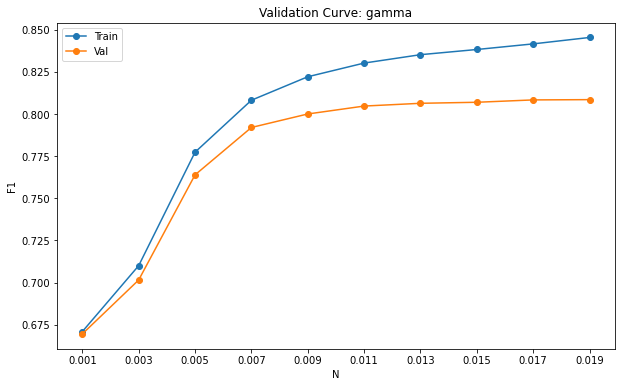

In [11]:
param='gamma'
param_range=np.array(range(1, 20, 2))/1000
clf=SVC(kernel='poly',  random_state=0)
tune(X_train, y_train, param, param_range, clf=clf)

Tuning Parameter: coef0
Best Parameter:  0.8
Best Score:  0.82


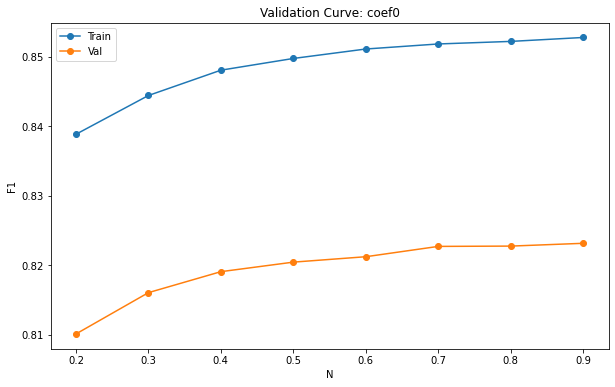

In [12]:
param='coef0'
param_range=np.array(range(20, 100, 10))/100
clf=SVC(kernel='poly',  random_state=0)
tune(X_train, y_train, param, param_range, clf=clf)

Tuning Parameter: gamma
Best Parameter:  0.003
Best Score:  0.818


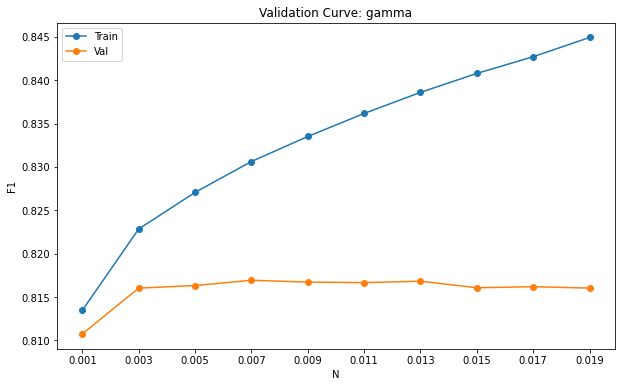

In [13]:
param='gamma'
param_range=np.array(range(1, 20, 2))/1000
clf=SVC(kernel='rbf', random_state=0)
tune(X_train, y_train, param, param_range, clf=clf)

In [14]:
def plot_learning_curve_svc(X_train, y_train, kf):
    clf=SVC(kernel='linear', random_state=0)

    
    train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, scoring='f1', cv=kf, random_state=0, shuffle=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    fig, ax =plt.subplots()
    fig.set_size_inches(10,6)
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Validation")
    ax.legend()
    ax.set_xlabel('Train size')
    ax.set_ylabel('F1')
    ax.set_title('Learning Curve: F1 to Train Size')

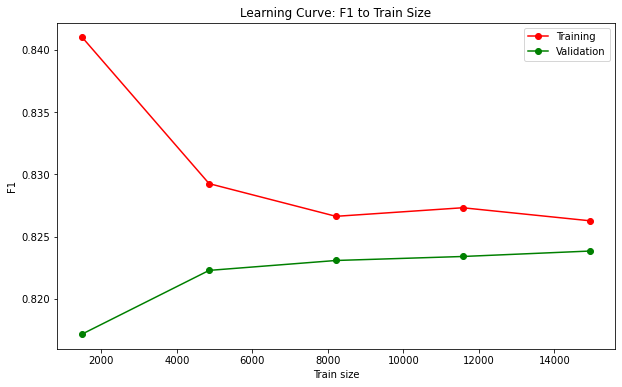

In [15]:
plot_learning_curve_svc(X_train, y_train, kf)

In [16]:
def final_model_svc(X_train, y_train, X_test, y_test):
    clf=SVC(kernel='linear', random_state=0)

    start=time.time()
    final=clf
    final.fit(X_train, y_train)

    pred_train=final.predict(X_train)
    pred_test=final.predict(X_test)

    train_score=f1_score(y_train, pred_train)
    test_score=f1_score(y_test, pred_test)
    
    cm=confusion_matrix(y_test, pred_test)
    runtime=round(time.time()-start, 3)
    
    print(color.BOLD+'Train F1: '+color.END, round(train_score, 3), '\n')
    print(color.BOLD+'Test F1: '+color.END, round(test_score, 3), '\n')
    print(color.BOLD+'Run Time:' +color.END, runtime , ' seconds', '\n')
    print(color.BOLD+'Confusion Matrix: '+color.END, '\n', cm)
    
    return train_score, test_score,  runtime, cm

In [17]:
train_score, test_score,  runtime, cm= final_model_svc(X_train, y_train, X_test, y_test)

0.826
0.618
Time: 36.091  seconds
Confusion Matrix:  
 [[4827 2587]
 [ 144 2211]]
